In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline


TODO: issues at github

TODO: mark all pauses 

TODO: copy working notebooks inot functions in the script + main folder


# the switching binomial generative model
## the data to model

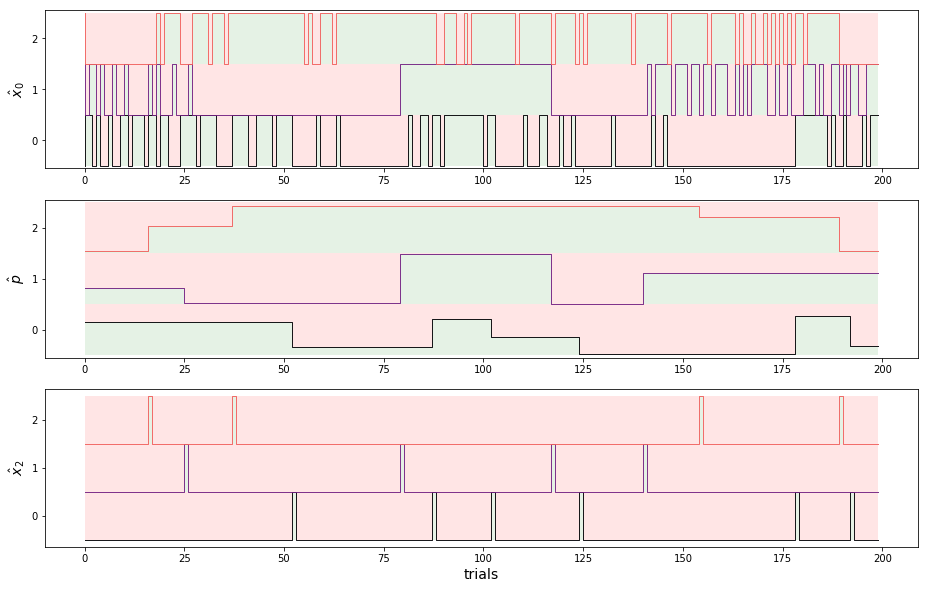

In [2]:
import sys
sys.path.append('..')

from aSPEM import binomial_motion, aSPEM

import time
a = aSPEM(mode='pari', timeStr = time.strftime("%Y-%m-%d_%H%M%S", time.localtime()))
fig, axs, p = a.plot()

In [3]:
p.shape

(200, 3, 3)

In [4]:
i_block = 0
print('occurrences=', p[:, i_block, 0])
print('p=', p[:, i_block, 1])
print('switches=', p[:, i_block, -1])

occurrences= [ 0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.  1.  0.  1.
  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.
  0.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  1.  1.]
p= [ 0.64752352  0.64752352  0.64752352  0.64752352  0.64752352  0.64752352
  0.64752352  0.64752352  0.64752352  0.64752352  0.64752352  0.64752352
  0.64752352  0.64752352 

In [5]:
N_trials = a.exp['N_trials']
h = 1./a.exp['tau']
print('this experiment uses', N_trials, 'trials and a switch rate of h=', h, '(that is, one switch every', 1/h, 'trials on average)')

this experiment uses 200 trials and a switch rate of h= 0.025 (that is, one switch every 40.0 trials on average)


In [16]:

def likelihood_(o, p, r, Z=None):
    """
    Un-normalized function
    for the beta-binomial probability of length 1, the likelihood of drawing o in {0, 1}
    is equal to 
        
    """
    if Z is None:
        Z = likelihood_(0, p, r, Z=1) + likelihood_(1, p, r, Z=1)
    return Z**-1 * ((1-o) / (1 + p*r) + o/(1+(1-p)*r))

def likelihood(o, p, r):
    """
    for the beta-binomial probability of length 1, the likelihood of drawing o in {0, 1}
    is equal to 
        
    """
    #return 1/(r+2) * ((1-o) * (1+(1-p)*r) + o* (1 + p*r))
    return .5 * (r==0) + ((1-o) * (1-p) + o * p) * (r>0)
    #return r / (r+1) * ((1-o) * (1-p) + o * p) 

for likelihood__ in [likelihood, likelihood_]:
    help(likelihood__)
    for p_ in [.25, .5, .75]:
        for r in (2**np.arange(5)-1):
            print('Knowing p=', p_, 'and r=', r, ', the likelihood for 0=', likelihood__(0, p_, r), ', for 1=', likelihood__(1, p_, r), ', sum=', likelihood__(0, p_, r)+likelihood__(1, p_, r))

Help on function likelihood in module __main__:

likelihood(o, p, r)
    for the beta-binomial probability of length 1, the likelihood of drawing o in {0, 1}
    is equal to

Knowing p= 0.25 and r= 0 , the likelihood for 0= 0.5 , for 1= 0.5 , sum= 1.0
Knowing p= 0.25 and r= 1 , the likelihood for 0= 0.75 , for 1= 0.25 , sum= 1.0
Knowing p= 0.25 and r= 3 , the likelihood for 0= 0.75 , for 1= 0.25 , sum= 1.0
Knowing p= 0.25 and r= 7 , the likelihood for 0= 0.75 , for 1= 0.25 , sum= 1.0
Knowing p= 0.25 and r= 15 , the likelihood for 0= 0.75 , for 1= 0.25 , sum= 1.0
Knowing p= 0.5 and r= 0 , the likelihood for 0= 0.5 , for 1= 0.5 , sum= 1.0
Knowing p= 0.5 and r= 1 , the likelihood for 0= 0.5 , for 1= 0.5 , sum= 1.0
Knowing p= 0.5 and r= 3 , the likelihood for 0= 0.5 , for 1= 0.5 , sum= 1.0
Knowing p= 0.5 and r= 7 , the likelihood for 0= 0.5 , for 1= 0.5 , sum= 1.0
Knowing p= 0.5 and r= 15 , the likelihood for 0= 0.5 , for 1= 0.5 , sum= 1.0
Knowing p= 0.75 and r= 0 , the likelihood for 0= 0

In [17]:
np.arange(0, 1+1)

array([0, 1])

In [18]:
from scipy.stats import beta
help(beta.ppf)
beta.ppf([.25, .75], a=14., b=14.)

Help on method ppf in module scipy.stats._distn_infrastructure:

ppf(q, *args, **kwds) method of scipy.stats._continuous_distns.beta_gen instance
    Percent point function (inverse of `cdf`) at q of the given RV.
    
    Parameters
    ----------
    q : array_like
        lower tail probability
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    x : array_like
        quantile corresponding to the lower tail probability q.



array([ 0.43596102,  0.56403898])

i_block= 0
time 0 ; obs= 0.0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.975 ; p_bar= [ 0.5]
belief [ 0.025  0.975]
time 1 ; obs= 1.0 ; beliefs= [ 0.025  0.975] ; p_hat= [ 0.5         0.16666667] ; 1-h= 0.975 ; p_bar= [ 0.5         0.16666667]
belief [ 0.025       0.06964286  0.90535714]
time 2 ; obs= 1.0 ; beliefs= [ 0.025       0.06964286  0.90535714] ; p_hat= [ 0.5         0.83333333  0.5       ] ; 1-h= 0.975 ; p_bar= [ 0.5         0.83333333  0.5       ]
belief [ 0.025       0.02329352  0.10814846  0.84355802]
time 3 ; obs= 0.0 ; beliefs= [ 0.025       0.02329352  0.10814846  0.84355802] ; p_hat= [ 0.5         0.16666667  0.1         0.35714286] ; 1-h= 0.975 ; p_bar= [ 0.5         0.83333333  0.9         0.64285714]
belief [ 0.025       0.03710409  0.0115238   0.032102    0.89427011]
time 4 ; obs= 1.0 ; beliefs= [ 0.025       0.03710409  0.0115238   0.032102    0.89427011] ; p_hat= [ 0.5         0.16666667  0.5         0.64285714  0.5       ] ; 1-h= 0.975 ; p_bar= [ 0.5         0.166

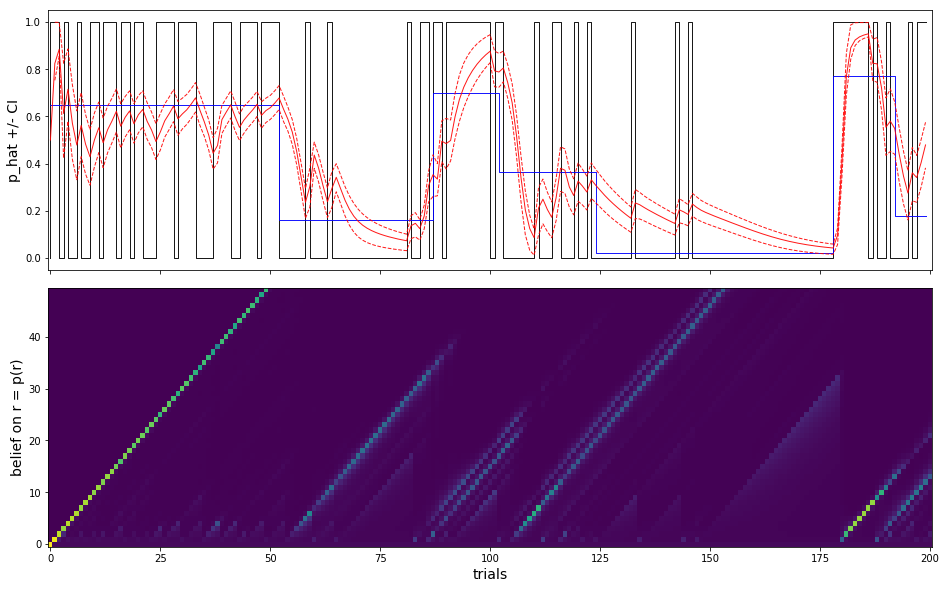

i_block= 1
time 0 ; obs= 1.0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.975 ; p_bar= [ 0.5]
belief [ 0.025  0.975]
time 1 ; obs= 0.0 ; beliefs= [ 0.025  0.975] ; p_hat= [ 0.5         0.16666667] ; 1-h= 0.975 ; p_bar= [ 0.5         0.83333333]
belief [ 0.025       0.06964286  0.90535714]
time 2 ; obs= 1.0 ; beliefs= [ 0.025       0.06964286  0.90535714] ; p_hat= [ 0.5         0.16666667  0.5       ] ; 1-h= 0.975 ; p_bar= [ 0.5         0.16666667  0.5       ]
belief [ 0.025       0.0255618   0.02373596  0.92570225]
time 3 ; obs= 1.0 ; beliefs= [ 0.025       0.0255618   0.02373596  0.92570225] ; p_hat= [ 0.5         0.83333333  0.5         0.64285714] ; 1-h= 0.975 ; p_bar= [ 0.5         0.83333333  0.5         0.64285714]
belief [ 0.025       0.01902027  0.03241282  0.01805857  0.90550834]
time 4 ; obs= 0.0 ; beliefs= [ 0.025       0.01902027  0.03241282  0.01805857  0.90550834] ; p_hat= [ 0.5         0.16666667  0.1         0.35714286  0.27777778] ; 1-h= 0.975 ; p_bar= [ 0.5         0.833

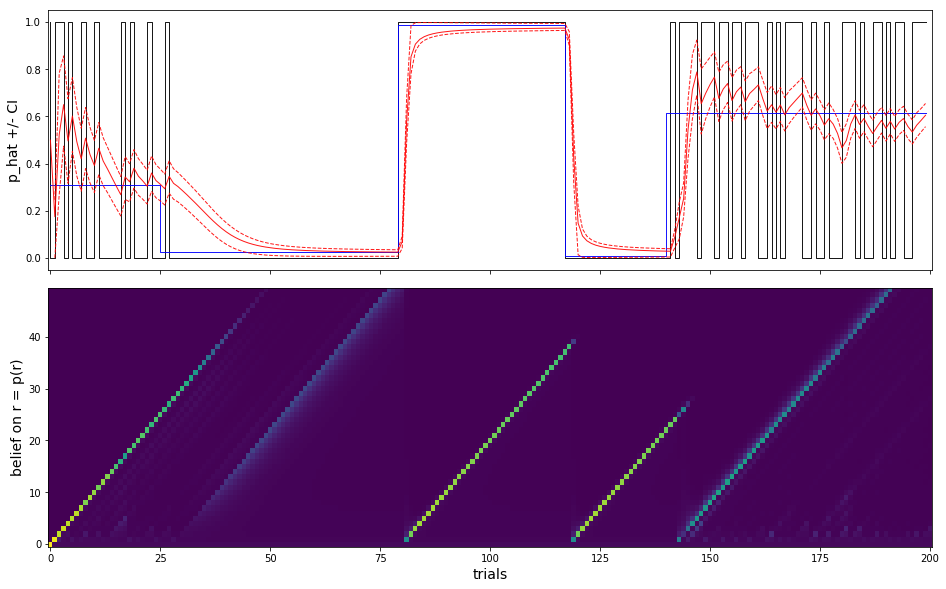

i_block= 2
time 0 ; obs= 1.0 ; beliefs= [ 1.] ; p_hat= [ 0.5] ; 1-h= 0.975 ; p_bar= [ 0.5]
belief [ 0.025  0.975]
time 1 ; obs= 0.0 ; beliefs= [ 0.025  0.975] ; p_hat= [ 0.5         0.16666667] ; 1-h= 0.975 ; p_bar= [ 0.5         0.83333333]
belief [ 0.025       0.06964286  0.90535714]
time 2 ; obs= 0.0 ; beliefs= [ 0.025       0.06964286  0.90535714] ; p_hat= [ 0.5         0.83333333  0.5       ] ; 1-h= 0.975 ; p_bar= [ 0.5         0.16666667  0.5       ]
belief [ 0.025       0.02329352  0.10814846  0.84355802]
time 3 ; obs= 0.0 ; beliefs= [ 0.025       0.02329352  0.10814846  0.84355802] ; p_hat= [ 0.5         0.83333333  0.9         0.64285714] ; 1-h= 0.975 ; p_bar= [ 0.5         0.16666667  0.1         0.35714286]
belief [ 0.025       0.0181488   0.02818328  0.14131903  0.78734889]
time 4 ; obs= 0.0 ; beliefs= [ 0.025       0.0181488   0.02818328  0.14131903  0.78734889] ; p_hat= [ 0.5         0.83333333  0.9         0.92857143  0.72222222] ; 1-h= 0.975 ; p_bar= [ 0.5         0.166

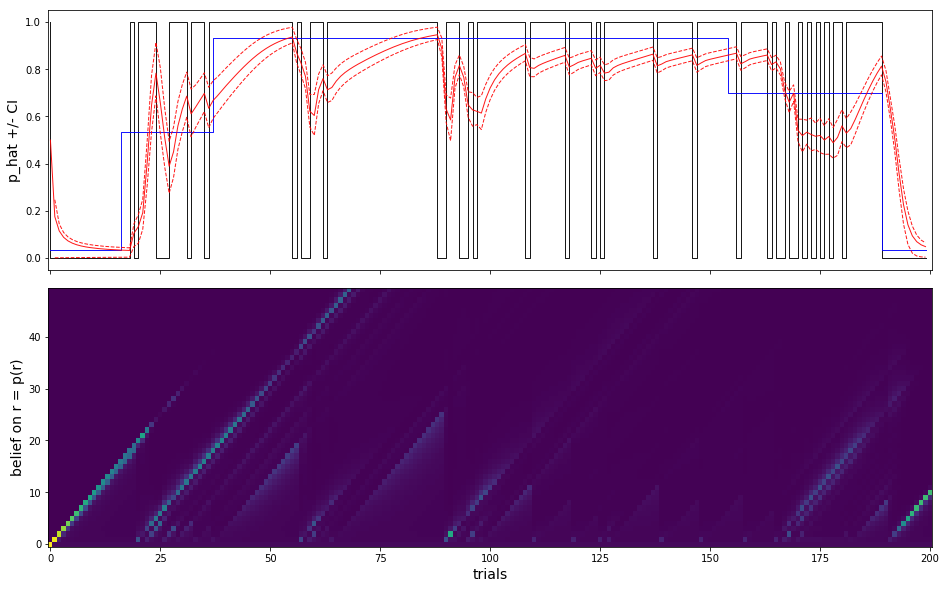

In [37]:
# -*- coding: utf8 -*-
"""
 An implementation of:
 @TECHREPORT{ adams-mackay-2007,
    AUTHOR = {Ryan Prescott Adams and David J.C. MacKay},
    TITLE  = "{B}ayesian Online Changepoint Detection",
    INSTITUTION = "University of Cambridge",
    ADDRESS = "Cambridge, UK",
    YEAR = "2007",
    NOTE = "arXiv:0710.3742v1 [stat.ML]"
 }
 
 adapted from
    url='https://github.com/laurentperrinet/bayesianchangepoint',
    
 by
    Copyright 2013 Jack Kelly (aka Daniel) jack@jack-kelly.com
    author='Jack Kelly',
    author_email='jack@jack-kelly.com',

which is adapted from the matlab code @

    http://hips.seas.harvard.edu/content/bayesian-online-changepoint-detection
    

"""
from __future__ import print_function, division
import numpy as np
from numpy.random import gamma, randn, rand
from scipy.special import gammaln

def plot_inference(self, o, p_true, p_bar, r, beliefs, mode=None, fig=None, axs=None, fig_width=13):
    N_trials = self.exp['N_trials']
    p_hat = np.sum(p_bar[:, 1:] * beliefs[:, :-1], axis=0)
    r_hat = np.sum(r * beliefs, axis=0)

    if fig is None:
        fig_width= fig_width
        fig, axs = plt.subplots(2, 1, figsize=(fig_width, fig_width/1.6180), sharex=True)
    axs[0].step(range(N_trials), o, lw=1, alpha=.9, c='k')
    axs[0].step(range(N_trials), p_true, lw=1, alpha=.9, c='b')
    from scipy.stats import beta
    p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
    for i_trial in range(N_trials):
        p_low[i_trial], p_sup[i_trial] = beta.ppf([.25, .75], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])
    
    axs[0].plot(range(N_trials), p_hat, lw=1, alpha=.9, c='r')
    axs[0].plot(range(N_trials), p_sup, 'r--', lw=1, alpha=.9)
    axs[0].plot(range(N_trials), p_low, 'r--', lw=1, alpha=.9)
    axs[1].imshow(beliefs[:50, :])

    fig.tight_layout()
    for i_layer, label in zip(range(2), ['p_hat +/- CI', 'belief on r = p(r)']): 
        axs[i_layer].set_xlim(0, N_trials)
        axs[i_layer].set_ylim(-.05, 1 + .05)
        axs[i_layer].axis('tight')
#            axs[i_layer].set_yticks(np.arange(1)+.5)
#            axs[i_layer].set_yticklabels(np.arange(1) )
        axs[i_layer].set_ylabel(label, fontsize=14)
        axs[i_layer].axis('tight')
    axs[-1].set_xlabel('trials', fontsize=14);

    return fig, axs

def inference(o, h=h, p0=.5):
    """
    Args:
      * o (np.ndarray): data
      
      * h (float): hazard rate, a value in the interval [0,1] that is the probability of a changepoint.

      * p0, r0 (float, float): specify initial values for beta-distribution.
      
      * alpha0, beta0 (float, float): specify prior beta-distribution for p.
        This data is Binomial with unknown mean.  We are going to
        use the standard conjugate prior of a beta-ditribution. ** Note that
        one cannot use non-informative priors for changepoint detection in
        this construction.  The beta-ditribution yields a closed-form
        predictive distribution, which makes it easy to use in this context. **
        
    Output:
      * beliefs (np.ndarray): beliefs about the current run lengths.
      * p_bar (np.ndarray): mean of the prediction about p.
    
        - the first axis records the estimated prebabilities
        for the different hypothesis of run lengths
        - the second axis is time (trials) - the system has only access to the present
        time, but this is a convenience for plots
    """
    T = o.size # total number of observations
    # First, setup the matrix that will hold our beliefs about the current
    # run lengths.  We'll initialize it all to zero at first.  
    beliefs = np.zeros((T+1, T+1))

    # INITIALIZATION
    # At time t=0, we actually have complete knowledge about the run
    # length.  It is zero.
    beliefs[0, 0] = 1.0

    # Track the current set of parameters.  These start out at the prior and
    # we accumulate data as we proceed.
    p_bar = np.zeros((T+1, T+1))
    p_bar[0, 0] = p0

    r = np.zeros((T+1, T+1))

    # Loop over the data like we're seeing it all for the first time.
    for t in range(T):
        #print('obs=', o[t])
        r[:(t+1), t] = np.arange(0, t+1)
        # Evaluate the predictive distribution for the next datum assuming that
        # we know the parameters p and r that generated the datum. 
        # This probability is computed over the set of possible run-lengths.
        #p_hat = np.ones_like(o[t])#
        p_hat = likelihood(o[t], p_bar[:(t+1), t], r[:(t+1), t])

        # Evaluate the growth probabilities
        # 
        if t <8: print('time', t, '; obs=', o[t], '; beliefs=', beliefs[:(t+1), t], '; p_hat=', p_hat, '; 1-h=', (1-h), '; p_bar=', p_bar[:(t+1), t])
        belief = np.zeros((t+2)) # ([1:(t+2), t+1]
        #print(t, belief.shape, belief[1:(t+2)])
        # iff there was no changepoint, shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        belief[1:] = beliefs[:(t+1), t] * p_hat * (1-h)

        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at beliefs = 0.
        belief[0] = np.sum(beliefs[:(t+1), t] * p_hat * h)

        # Renormalize the run length probabilities by calculating total evidence
        belief = belief / np.sum(belief)
        beliefs[:(t+2), t+1] = belief
        if t <8: print('belief', belief)

        # Update the sufficient statistics for each possible run length.
        p_bar[0, t+1] = p0 # TODO : introduce Jeffrey's prior into that inference
        p_bar[1:(t+2), t+1] = (1-1/(r[:(t+1), t]+1.5)) * p_bar[:(t+1), t] + 1/(r[:(t+1), t]+1.5) * o[t]
        #r[0, t+1] = .5 # 
        #r[:(t+2), t+1] = np.arange(0, t+2)
        #print(r[1:(t+2), t+1])
        #if t > 8 : break
    return p_bar, r, beliefs

for i_block in range(3):
    print('i_block=', i_block)
    o = p[:, i_block, 0]
    p_bar, r, beliefs = inference(o, h=h, p0=.5)

    fig, axs = plot_inference(a, p[:, i_block, 0], p[:, i_block, 1], p_bar, r, beliefs)
    plt.show()

In [38]:
beliefs[0, :]

array([ 1.   ,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
        0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,  0.025,
      

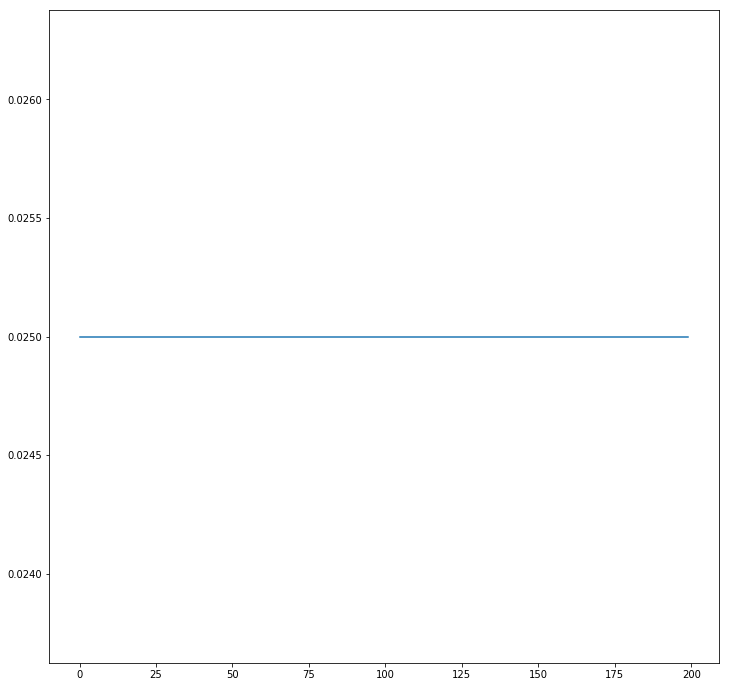

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.plot(beliefs[0, 1:])

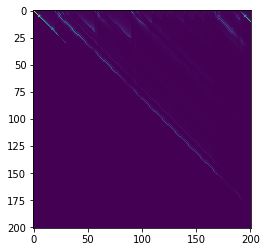

In [31]:
plt.imshow(beliefs)

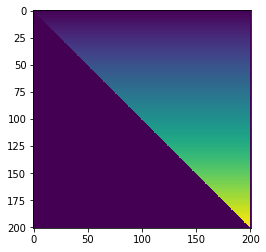

In [26]:
plt.imshow(r)

In [27]:
r[:4, :4]

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  1.],
       [ 0.,  0.,  2.,  2.],
       [ 0.,  0.,  0.,  3.]])

In [15]:
np.sum(p_bar * beliefs, axis=0)

array([ 0.5       ,  0.9875    ,  0.48194444,  0.31400961,  0.23077304,
        0.18137288,  0.14882837,  0.12586738,  0.10886154,  0.0958011 ,
        0.08548447,  0.07714994,  0.07029184,  0.06456155,  0.05971117,
        0.05555973,  0.05197212,  0.04884549,  0.04610022,  0.04367377,
        0.24153669,  0.13000295,  0.3333727 ,  0.57339573,  0.7405879 ,
        0.82807415,  0.60196846,  0.45361359,  0.34970028,  0.5031667 ,
        0.59518558,  0.66048963,  0.70999208,  0.58707968,  0.65349541,
        0.69350796,  0.72546843,  0.62348596,  0.67956124,  0.71029933,
        0.73513456,  0.75691167,  0.77657118,  0.79455865,  0.81112617,
        0.8264312 ,  0.84057934,  0.85364672,  0.8656931 ,  0.87677003,
        0.88692588,  0.89620876,  0.90466794,  0.9123543 ,  0.91932004,
        0.92561803,  0.93130103,  0.74964691,  0.84449617,  0.67604151,
        0.46429191,  0.6675562 ,  0.74485484,  0.78367226,  0.65939807,
        0.73490693,  0.76823082,  0.78965548,  0.80535976,  0.81